In [ ]:
# Provo a usare Orange per fare discretizzazione

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


from Orange.data import Table, Domain, ContinuousVariable, DiscreteVariable
from Orange.preprocess import Discretize
from Orange.preprocess.discretize import EntropyMDL

from sklearn.preprocessing import KBinsDiscretizer





PERCENTILES = [1, 5, 10, 15, 20] # Top 1%, 5%, 10%, 15%, 20% of predictions
ITERATIONS = 100  # Bootstrap iterations
COLORS = ['#323694', '#039573', '#feea2a'] # Color palette for the classifiers


# CMIM ranking of features 
CMIM_SC_NO_GENPROT = ['paralagous_count', 'upstream_size',  'CAI', 'GLU',
                'aromaticity_score', 'Gravy_score', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG',  'Codon_bias']

CMIM_SC_GENPROT = ['phyletic_retention', 'paralagous_count', 'upstream_size',  'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG']

CMIM_SC_ALL = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus',
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP',
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS',
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG',
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule',
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']





class EssentiallyClassifier:
    """
    Abstract class for the essentiality classifier.
    Contains the main methods to load the data, find the optimal number of features and plot the results.
    """



    def __init__(self, file_path, cmim_ranking, percentiles,name):
        self.name = name # Name of classifier
        self.file_path = file_path # Path to the excel file
        self.cmim_ranking = cmim_ranking # CMIM ranking of features 
        self.percentiles = percentiles # Top percentiles 
        self.X = None
        self.y = None
        self.optimal_features = None
        self.highest_ppv_1 = 0 # Highest PPV (1%), used to find optimal number of features 
        self.final_ppv_scores = []



    def load_discretized_data(self):
        """
        Loads and processes discretized data from an Excel file.
        Reads data and uses a label encoder to convert symbols to integers.
        """

        self._load_data()
        return;

        discretized_data = pd.read_excel(self.file_path, sheet_name='entropy discretized')
        columns_with_symbols = discretized_data.columns[2:]
        label_encoders = {}

        for column in columns_with_symbols:
            le = LabelEncoder()
            discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
            label_encoders[column] = le

        self.X = discretized_data.drop(columns=['Essential', 'orf_id'])
        self.y = discretized_data['Essential']

        print("Data loaded successfully, shape:", self.X.shape, self.y.shape)




    def _lodad_data_and_discretize_with_sklearn(self):
        """
        Load the data from the Excel file and discretize it using sklearn.
        """

        # Load data from Excel file
        not_discretized_data = pd.read_excel(self.file_path)
        print("Original shape:", not_discretized_data.shape)
        
        # Remove unwanted columns and separate target
        y = not_discretized_data['Essential']
        not_discretized_data = not_discretized_data.drop(columns=['orf_id'])
        
        # Discretize data using MDLP
      
        discretizer = MDLP_Discretizer(raw_data_shape=not_discretized_data.shape)
        discretized_data = discretizer.fit(not_discretized_data.values, y)
        discretized_data = discretizer.transform(not_discretized_data.values)

        # Reconstruct the dataframe
        discretized_df = pd.DataFrame(discretized_data, columns=not_discretized_data.columns)
        discretized_df['Essential'] = y

        # Save X (features) and y (target)
        self.X = discretized_df.drop(columns=['Essential'])
        self.y = discretized_df['Essential']

        print("Final X shape:", self.X.shape)
        print("Final y shape:", self.y.shape)
        print(self.X.head())
        print("Data loaded successfully")




    def _load_orange_discretized_data(self):
        # Load the pre-discretized data
        discretized_data = pd.read_excel(self.file_path)
        print("Original shape:", discretized_data.shape)
        
        # Extract target and drop unwanted columns
        y = discretized_data['Essential']
        if 'orf_id' in discretized_data.columns:
            discretized_data = discretized_data.drop(columns=['orf_id'])
        discretized_data = discretized_data.drop(columns=['Essential'])
        
        # Clean and encode string values for each column
        encoded_data = discretized_data.copy()
        encoders = {}
        
        for column in encoded_data.columns:
            # Strip whitespace and handle any special characters
            encoded_data[column] = encoded_data[column].astype(str).str.strip()
            
            # Create a LabelEncoder for this column
            le = LabelEncoder()
            encoded_data[column] = le.fit_transform(encoded_data[column])
            encoders[column] = le
        
        # Create domain with discrete variables
        domain = Domain(
            [DiscreteVariable(name=col, values=[str(v) for v in range(len(encoders[col].classes_))])
            for col in encoded_data.columns],
            DiscreteVariable('Essential', values=['0', '1'])
        )
        
        # Convert to Orange Table
        orange_data = Table.from_numpy(
            domain,
            X=encoded_data.values,
            Y=y.values.reshape(-1, 1)
        )
        
        # Store the data
        self.X = pd.DataFrame(orange_data.X, columns=encoded_data.columns)
        self.y = pd.Series(orange_data.Y.flatten(), dtype=int)
        
        # Store encoders for later use if needed
        self.encoders = encoders
        
        print("Final X shape:", self.X.shape)
        print("Final y shape:", self.y.shape)
        
        return self.X, self.y

    def _load_data(self):
        # Load data from Excel file
        not_discretized_data = pd.read_excel(self.file_path)
        print("Original shape:", not_discretized_data.shape)
        
        # Remove unwanted columns and separate target
        y = not_discretized_data['Essential']
        not_discretized_data = not_discretized_data.drop(columns=['orf_id'])
        
        # Convert non-numeric columns to numeric
        not_discretized_data = not_discretized_data.apply(pd.to_numeric, errors='coerce')
        
        # Fill missing values
        not_discretized_data = not_discretized_data.fillna(not_discretized_data.mean())
        
        # Create domain with all variables
        domain = Domain(
            [ContinuousVariable(col) for col in not_discretized_data.columns if col != 'Essential'],
            DiscreteVariable('Essential', values=['0', '1'])
        )
        
        # Convert to Orange Table
        orange_data = Table.from_numpy(
            domain,
            X=not_discretized_data.drop(columns=['Essential']).values,
            Y=y.values.reshape(-1, 1)
        )
        
        # Apply discretization with custom handling
        discretizer = Discretize(method=EntropyMDL())
        discretized_data = discretizer(orange_data)
        
        # Handle cases where discretization removes variables
        all_columns = not_discretized_data.drop(columns=['Essential']).columns
        discretized_df = pd.DataFrame(discretized_data.X, columns=[var.name for var in discretized_data.domain.attributes])
        
        # Add back removed columns with a simple equal-width discretization
        removed_columns = set(all_columns) - set(discretized_df.columns)
        if removed_columns:
            for col in removed_columns:
                # Get original data
                col_data = not_discretized_data[col]
                # Restore the original column
                discretized_df[col] = col_data
                
              
        
        # Add target variable back
        discretized_df['Essential'] = pd.Series(discretized_data.Y.flatten(), dtype=int)
        
        # Save X (features) and y (target)
        self.X = discretized_df.drop(columns=['Essential'])
        self.y = discretized_df['Essential']
        
        print("Final X shape:", self.X.shape)
        print("Final y shape:", self.y.shape)
        print("Original columns preserved - no columns removed")
        
        return self.X, self.y



    def calculate_top_percentile_ppv(self, probabilities, true_labels):
        """
        Calculate the positive predictive value (PPV) for the top percentiles of predictions.

        Parameters:
            - probabilities: Array of predicted probabilities.
            - true_labels: Grand truth labels.
        
        Returns:
        - PPV values for each specified percentile in self.percentiles.
        """

        if len(probabilities) != len(true_labels):
            raise ValueError("Length of probabilities and true labels must be the same.")

        sorted_indices = np.argsort(probabilities)[::-1] # Sort probabilities in descending order so that the top probabilities are first
        sorted_labels = true_labels[sorted_indices] # Sort true labels according to the sorted probabilities
        ppv_percentiles = []

        for p in self.percentiles:
            n_top = int(len(sorted_labels) * (p / 100)) # Calc the number of top predictions to consider
            if n_top == 0:
                ppv_percentiles.append(0)
            else:
                top_labels = sorted_labels[:n_top]
                # def: PPV = TP / (TP + FP)
                ppv = np.sum(top_labels) / len(top_labels)
                ppv_percentiles.append(ppv)

        return ppv_percentiles


       

    def find_optimal_features(self):
        """
        Find the optimal number of features to use by evaluating the classifier with different number of features taken ordered by CMIM ranking.
        """

        # Only features of the feature set 
        X_ranked = self.X[self.cmim_ranking]


        print("Starting to find optimal number of features...")


        # Iterate over all the features in the specific CMIM ranking
        for i in range(len(self.cmim_ranking), 0, -1):
            X_selected = X_ranked.iloc[:, :i]


            # Evaluate the model with the selected features
            ppv = self.evaluate_model(X_selected)
            
            ppv_1 = ppv[0] # PPV (1%)
            print(f"Features: {i}, PPV (1%): {ppv_1}")

            # Update the highest PPV (1%) and optimal number of features
            if ppv_1 > self.highest_ppv_1:
                self.highest_ppv_1 = ppv_1
                self.optimal_features = i


        # Print the results
        print("Highest PPV (1%):", self.highest_ppv_1)
        print("Optimal number of features:", self.optimal_features)



    def evaluate_final_model(self):
        """
        Evaluate the final model with the optimal number of features.
        """

        if self.optimal_features is None:
            raise ValueError("Optimal number of features to use has not been found.") 

        # Use the optimal number of features found empirically
        X_optimal = self.X[self.cmim_ranking].iloc[:, :self.optimal_features]


        # Evaluate the model with the optimal number of features
        self.final_ppv_scores = self.evaluate_model(X_optimal)

    
        print("Final PPV Percentiles:", self.final_ppv_scores)
        return self.final_ppv_scores



    def plot_ppv_results(self, ppv):
        """
        Plot the PPV results for the final model and compare with random predictions.

        Parameters:
            - ppv: Array of PPV values for the top percentiles of predictions of the classifier.
        """

        fig, ax = plt.subplots(figsize=(10, 6))
        percentiles_labels = [f'{p}%' for p in self.percentiles]
        random_ppv = [np.mean(self.y)] * len(self.percentiles)
        bar_with = 0.2

        ax.bar(np.arange(len(self.percentiles)) - bar_with / 2, ppv, bar_with, label=self.name, color='blue')
        ax.bar(np.arange(len(self.percentiles)) + bar_with / 2, random_ppv, bar_with, label='Random', color='black')
        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(f'PPV for {self.name} vs Random')
        ax.set_xticks(np.arange(len(self.percentiles)))
        ax.set_xticklabels(percentiles_labels)
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.legend()
        fig.tight_layout()
        plt.show()



    def run(self):
        """
        Build, optimize and evaluate the classifier.
        """

        self.load_discretized_data()
        self.find_optimal_features()
        ppvs = self.evaluate_final_model()
        self.plot_ppv_results(ppvs)



    def evaluate_model(self, X_selected):
        """
        Evaluate the model with the selected features and calculate the PPV for the top percentiles of predictions.

        Parameters:
        - X_selected: Selected features to use for the model.
        
        Returns:
        - PPV values for the top percentiles of predictions.

        Needs to be implemented by the subclass.
        """
        pass



class EssentiallyBayesClassifier(EssentiallyClassifier):
    """
    Naive Bayes classifier for the essentiality prediction.
    """


    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles ,name)


    def calcolate_boostrap_iteration(self, X_selected):
        """
        Helper function to calculate the single bootstrap iteration for the Naive Bayes classifier.

        Parameters:
            - X_selected: Selected features to use.

        Returns:
            - PPV values for the top percentiles of predictions.
        """


        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)


        # TODO

        # X_train_minority = X_train[y_train == 1]
        # y_train_minority = y_train[y_train == 1]

        # X_train_oversampled, y_train_oversampled = resample(
        #     X_train_minority, y_train_minority,
        #     replace=True,
        #     n_samples=np.sum(y_train == 0),
        #     random_state=42
        # )

        # X_train_oversampled = X_train_minority
        # y_train_oversampled = y_train_minority

        # X_train_balanced = pd.concat([X_train[y_train == 0], X_train_oversampled])
        # y_train_balanced = pd.concat([y_train[y_train == 0], y_train_oversampled])

        X_train_balanced = X_train
        y_train_balanced = y_train

        # Train the Naive Bayes classifier
        nb_classifier = GaussianNB()
        nb_classifier.fit(X_train_balanced, y_train_balanced)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]

        return self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())

   
    # Override 
    def evaluate_model(self, X_selected):
        all_ppvs = []
        for _ in range(ITERATIONS):  # Bootstrap iterations
            ppv_iteration = self.calcolate_boostrap_iteration(X_selected)
            all_ppvs.append(ppv_iteration)


        print("All PPVs of interations:", all_ppvs)
        # Calculate the mean PPV for each percentile over all iterations
        final_ppv = np.mean(all_ppvs, axis=0)
        return final_ppv




class EssentialityRandomForestClassifier(EssentiallyClassifier):
    """
    Random Forest classifier for the essentiality prediction.
    """


    def __init__(self, file_path, cmim_ranking, percentiles, name):
        super().__init__(file_path, cmim_ranking, percentiles,name)

   
    # Override
    def evaluate_model(self, X_selected):

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        X_train_minority = X_train[y_train == 1]
        y_train_minority = y_train[y_train == 1]

        X_train_oversampled, y_train_oversampled = resample(
            X_train_minority, y_train_minority,
            replace=True,
            n_samples=np.sum(y_train == 0),
            random_state=42
        )

        # X_train_balanced = pd.concat([X_train[y_train == 0], X_train_oversampled])
        # y_train_balanced = pd.concat([y_train[y_train == 0], y_train_oversampled])

        X_train_balanced = X_train
        y_train_balanced = y_train


        # Build the Random Forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

        # Train the Random Forest classifier
        rf_classifier.fit(X_train_balanced, y_train_balanced)
        y_prob = rf_classifier.predict_proba(X_test)[:, 1]

        ppv_iteration = self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())
        return ppv_iteration




class EssentialityExperiment:
    def __init__(self, name, classifiers):
        self.name = name # Name of the experiment
        self.classifiers = classifiers # Classifiers to run and compare

    def run_experiment(self):
        """
        Runs all the classifiers and evaluates their performance.
        """

        print("-" * 80)
        print(f"Running experiment for {self.name}")
        print("Classifiers: ", [classifier.name for classifier in self.classifiers])
        print("-" * 80)


        for classifier in self.classifiers:
            print(f"Running classifier {classifier.name}")
            print("-" * 50)
            classifier.run()
    
    def plot_comparative_results(self, percentiles, colors=None):
        """
        Plot the comparative results of the classifiers.
        """

        if colors is None:
            colors = plt.cm.get_cmap('tab10').colors # get default color map if not specified

        fig, ax = plt.subplots(figsize=(10, 6))
        labels = [f'{p}%' for p in percentiles]
        x = np.arange(len(percentiles))
        bar_width = 0.1
        gap = 0.03  # Gap between bars in the same group

        # Plot the PPV scores for each classifier
        for idx, classifier in enumerate(self.classifiers):
            ax.bar(x + idx * (bar_width + gap), 
                np.array(classifier.final_ppv_scores) * 100,  
                bar_width, 
                label=classifier.name, 
                color=colors[idx % len(colors)],
                edgecolor='black', 
                linewidth=0.4)  

        # Random predictions
        random_ppv = [np.mean(self.classifiers[0].y) * 100] * len(percentiles)
        ax.bar(x + (len(self.classifiers)) * (bar_width + gap), 
            random_ppv, 
            bar_width, 
            label='Random', 
            color='black', 
            edgecolor='black', 
            linewidth=0.5)

        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(self.name)
        ax.set_xticks(x + (len(self.classifiers) / 2) * (bar_width + gap) )
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 100) 
        ax.legend()
        fig.tight_layout()

        plt.show()


    def plot_comparative_table(self):
        """
        Plot a comparative table of the final PPV scores for each classifier.
        """
 
        rows = []
        for classifier in self.classifiers:
            if len(classifier.final_ppv_scores) != len(PERCENTILES):
                raise ValueError(
                    f"Inconsistent length for classifier '{classifier.name}': "
                    f"expected {len(PERCENTILES)} scores, got {len(classifier.final_ppv_scores)}."
                )
            rounded_scores = [str(round(score, 2)) for score in classifier.final_ppv_scores]
            rows.append(
                [classifier.name] + rounded_scores + [classifier.optimal_features]
            )

        # Create DataFrame
        columns = ['Classifier'] + [f'{p}%' for p in PERCENTILES] + ['Number of Features']
        table_df = pd.DataFrame(rows, columns=columns)
        table_df.set_index('Classifier', inplace=True)

        # Define a color palette for each row
        colors = [f'{color}50' for color in COLORS]  # Add alpha chanel to colors
        color_map = {classifier.name: colors[i % len(colors)] for i, classifier in enumerate(self.classifiers)}

     
        def highlight_row(row):
            classifier = row.name
            color = color_map.get(classifier, '#FFFFFF')  
            return [f'background-color: {color};'] * len(row)

        styled_df = table_df.style.apply(highlight_row, axis=1)


        styled_df = styled_df.set_table_attributes('style="font-size: 14px; border-collapse: collapse;"')

        return styled_df




Original shape: (4728, 63)
Final X shape: (4728, 61)
Final y shape: (4728,)
Original columns preserved - no columns removed
Starting to find optimal number of features...
All PPVs of interations: [[0.4782608695652174, 0.5169491525423728, 0.5254237288135594, 0.4943502824858757, 0.4978813559322034], [0.5652173913043478, 0.5338983050847458, 0.5423728813559322, 0.5254237288135594, 0.5], [0.5217391304347826, 0.5084745762711864, 0.5084745762711864, 0.5084745762711864, 0.4766949152542373], [0.4782608695652174, 0.559322033898305, 0.559322033898305, 0.5423728813559322, 0.510593220338983], [0.4782608695652174, 0.4915254237288136, 0.5296610169491526, 0.5254237288135594, 0.5233050847457628], [0.4782608695652174, 0.559322033898305, 0.5211864406779662, 0.5225988700564972, 0.5148305084745762], [0.5652173913043478, 0.559322033898305, 0.5508474576271186, 0.5508474576271186, 0.5127118644067796], [0.5652173913043478, 0.5932203389830508, 0.5677966101694916, 0.556497175141243, 0.5169491525423728], [0.39130

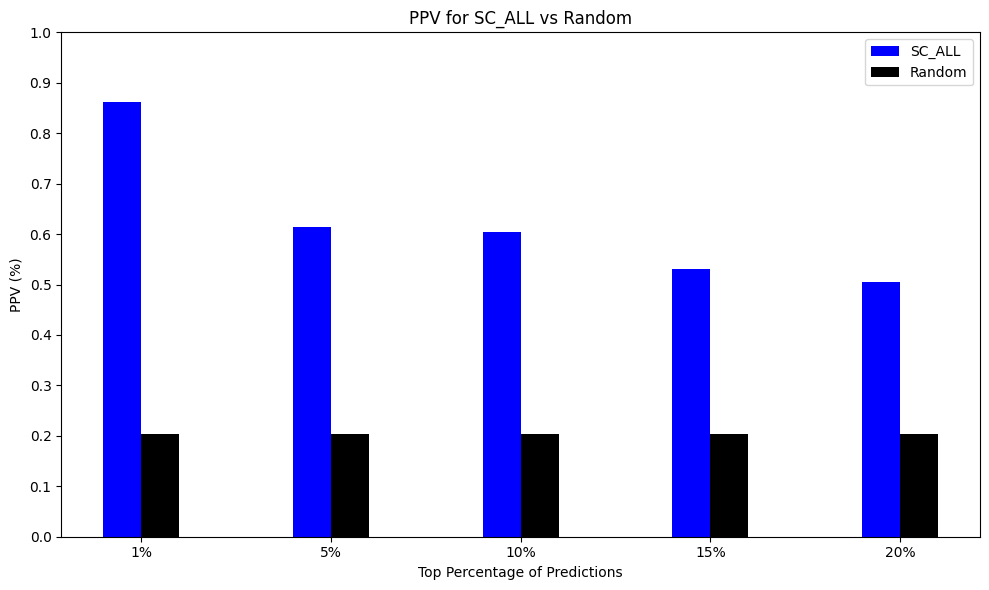

In [73]:
classifier_all = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')
classifier_all.run()



--------------------------------------------------------------------------------
Running experiment for S. cerevisiae
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Original shape: (4728, 63)
Final X shape: (4728, 61)
Final y shape: (4728,)
Original columns preserved - no columns removed
Starting to find optimal number of features...
All PPVs of interations: [[0.43478260869565216, 0.4915254237288136, 0.4915254237288136, 0.4858757062146893, 0.4639830508474576], [0.4782608695652174, 0.4745762711864407, 0.5211864406779662, 0.5084745762711864, 0.4851694915254237], [0.4782608695652174, 0.4745762711864407, 0.5211864406779662, 0.5141242937853108, 0.4915254237288136], [0.43478260869565216, 0.5, 0.5508474576271186, 0.5254237288135594, 0.4936440677966102], [0.6086956521739131, 0.5932203389830508, 0.5084745762711864, 0.5112994350282

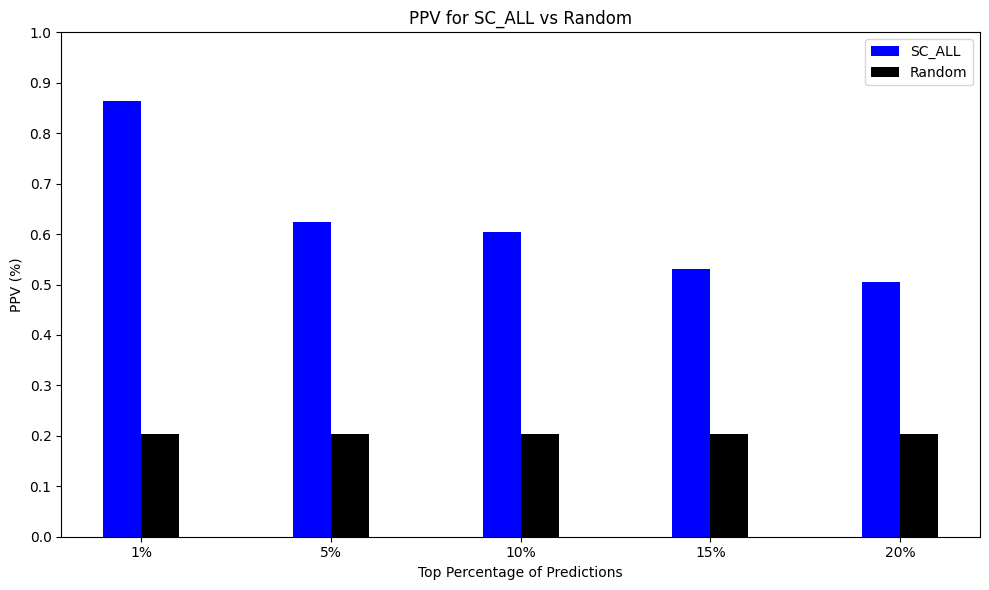

Running classifier SC_GENPROT
--------------------------------------------------
Original shape: (4728, 63)
Final X shape: (4728, 61)
Final y shape: (4728,)
Original columns preserved - no columns removed
Starting to find optimal number of features...
All PPVs of interations: [[0.8260869565217391, 0.5254237288135594, 0.461864406779661, 0.4745762711864407, 0.4427966101694915], [0.782608695652174, 0.5423728813559322, 0.4872881355932203, 0.4717514124293785, 0.461864406779661], [0.6521739130434783, 0.4152542372881356, 0.4576271186440678, 0.4406779661016949, 0.413135593220339], [0.7391304347826086, 0.5677966101694916, 0.5084745762711864, 0.5, 0.4661016949152542], [0.782608695652174, 0.5254237288135594, 0.4957627118644068, 0.480225988700565, 0.4597457627118644], [0.782608695652174, 0.5254237288135594, 0.4915254237288136, 0.4604519774011299, 0.4470338983050847], [0.7391304347826086, 0.4830508474576271, 0.5169491525423728, 0.4830508474576271, 0.4385593220338983], [0.7391304347826086, 0.6016949

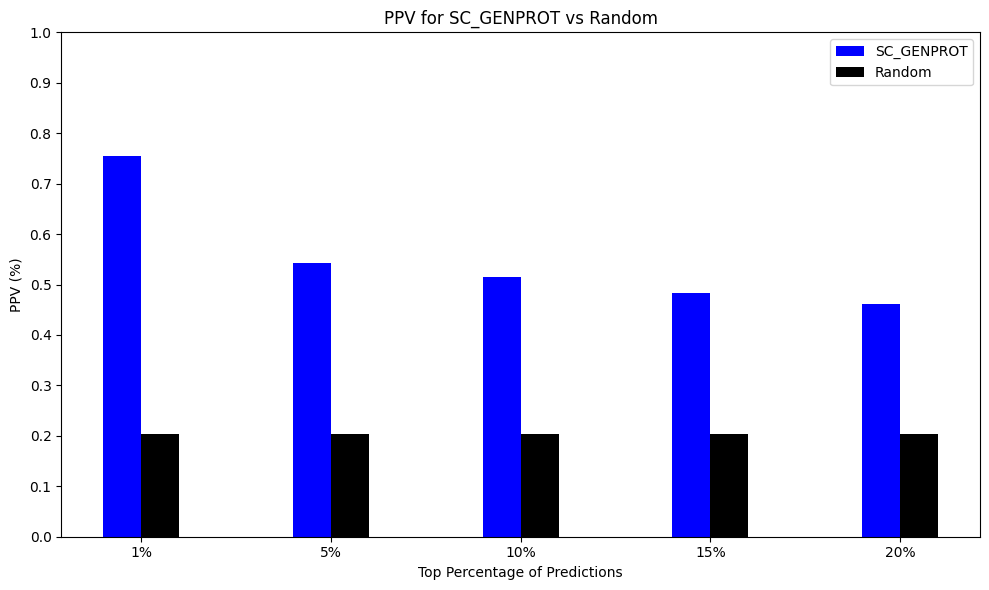

Running classifier SC_NO_GENPROT
--------------------------------------------------
Original shape: (4728, 63)
Final X shape: (4728, 61)
Final y shape: (4728,)
Original columns preserved - no columns removed
Starting to find optimal number of features...
All PPVs of interations: [[0.782608695652174, 0.5084745762711864, 0.4449152542372881, 0.4180790960451977, 0.3686440677966102], [0.6086956521739131, 0.4745762711864407, 0.4025423728813559, 0.3870056497175141, 0.3622881355932203], [0.6086956521739131, 0.4915254237288136, 0.3940677966101695, 0.3446327683615819, 0.3453389830508475], [0.4782608695652174, 0.4745762711864407, 0.4025423728813559, 0.3954802259887006, 0.3622881355932203], [0.5652173913043478, 0.4152542372881356, 0.3686440677966102, 0.3446327683615819, 0.3389830508474576], [0.43478260869565216, 0.4915254237288136, 0.4322033898305085, 0.3813559322033898, 0.3601694915254237], [0.4782608695652174, 0.4661016949152542, 0.4152542372881356, 0.3672316384180791, 0.3580508474576271], [0.47

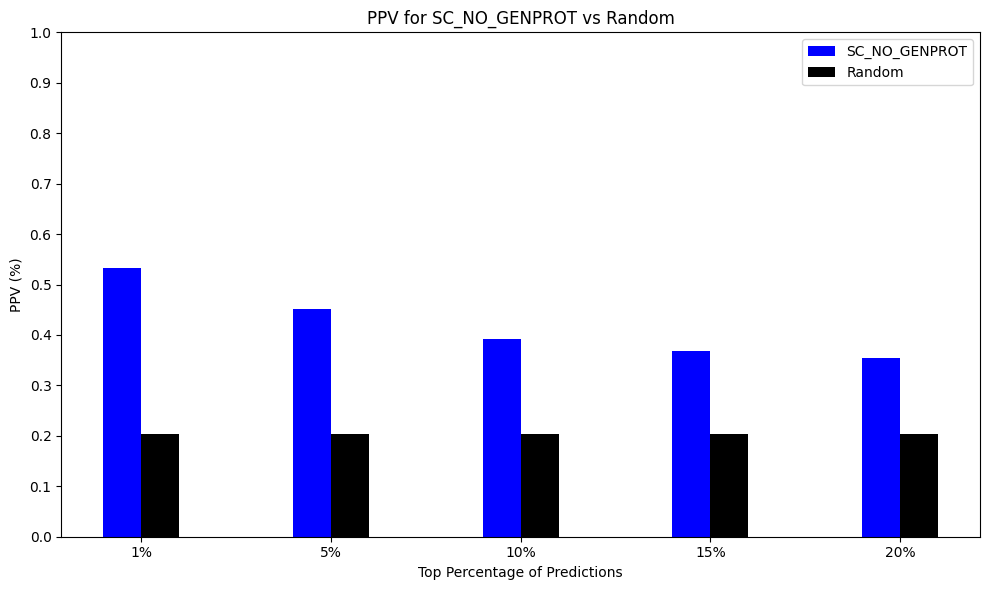

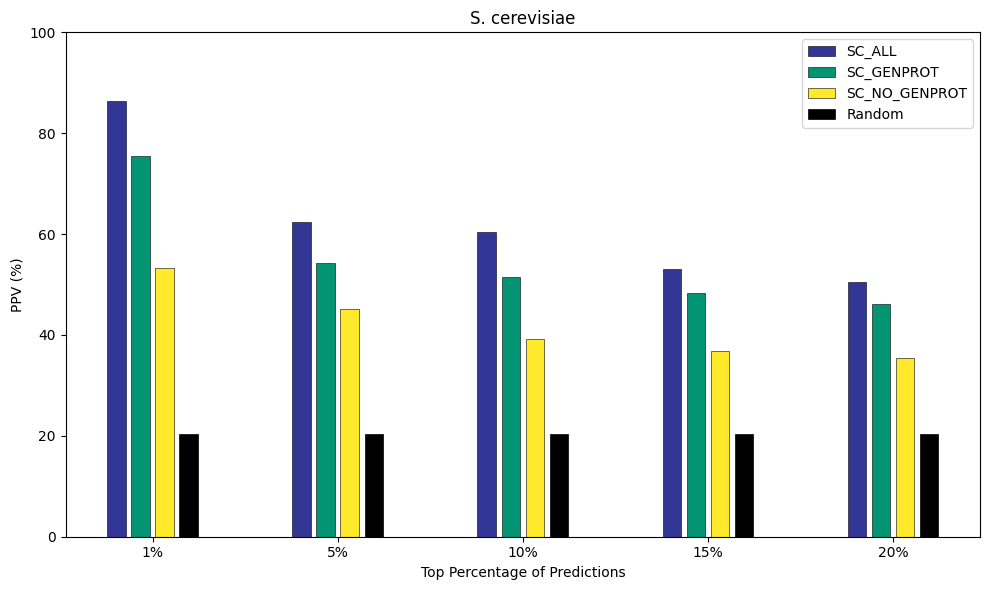

,1%,5%,10%,15%,20%,Number of Features
Classifier,,,,,,
SC_ALL,0.86,0.62,0.6,0.53,0.5,4
SC_GENPROT,0.75,0.54,0.52,0.48,0.46,15
SC_NO_GENPROT,0.53,0.45,0.39,0.37,0.35,15


In [74]:


classifier_no_genprot = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, name='SC_NO_GENPROT')
classifier_genprot = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, name='SC_GENPROT')
classifier_all = EssentiallyBayesClassifier('assets/cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae", [classifier_all, classifier_genprot, classifier_no_genprot])
experiment.run_experiment()
experiment.plot_comparative_results(PERCENTILES, colors=COLORS)
experiment.plot_comparative_table()



In [7]:


classifier_no_genprot = EssentialityRandomForestClassifier('cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, ITERATIONS, name='SC_NO_GENPROT')
classifier_genprot = EssentialityRandomForestClassifier('cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, ITERATIONS, name='SC_GENPROT')
classifier_all = EssentialityRandomForestClassifier('cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, ITERATIONS, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae Random Forest", [classifier_all,classifier_genprot, classifier_no_genprot])
experiment.run_experiment()
experiment.plot_comparative_results(PERCENTILES, colors=['#323694', '#039573', '#feea2a'])



TypeError: EssentialityRandomForestClassifier.__init__() got multiple values for argument 'name'